In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cv2 as cv
import scipy
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham

In [2]:
robot = np.ones((25,25))    # Initialize scaled robot (50x50 robot in 2x2 scale is 25x25 with scale 1x1)

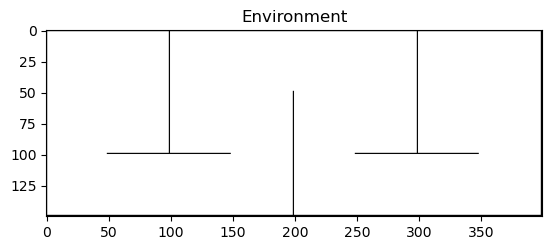

In [3]:
# Initialize map
H,W = 150, 400
map = np.zeros((H,W))

# Map edges
map[0,:] = 1
map[-1,:] = 1
map[:,0] = 1
map[:,-1] = 1

# # Horizontal walls
map[99, 49:149] = 1
map[99, 249:349] = 1

# # Vertical walls
map[0:99, 99] = 1
map[49:149, 199] = 1
map[0:99, 299] = 1


plt.title('Environment')
plt.imshow(map, cmap='gray_r')
plt.show()

# Part 1: Configuration space

We create the configuration space by creating a Minkowski sum of the robot with the obstacles. After the configuration space is computed, the path planning problem reduces to that of a point robot, which is much simpler and can be implemented with existing algorithms. For this problem, we use convolution to create the C-space.

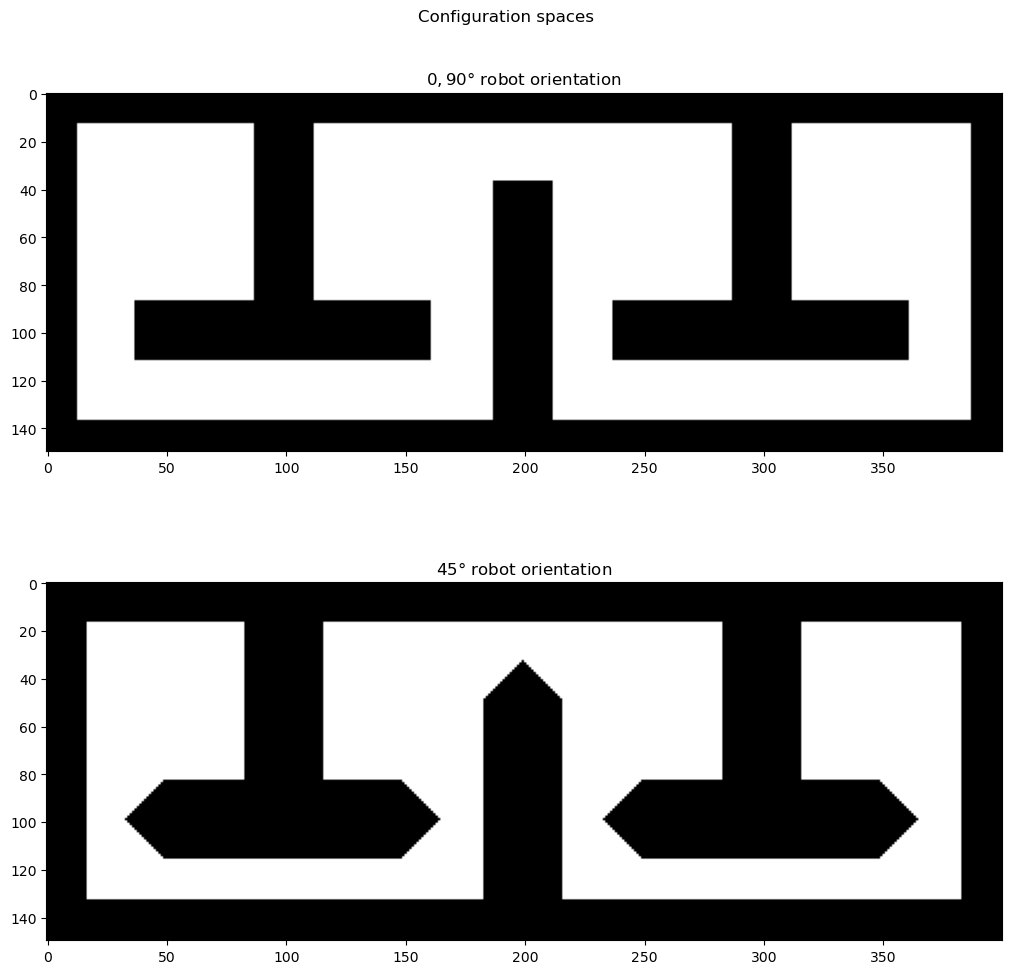

In [4]:
config0 = np.sign(scipy.signal.convolve2d(map, robot, mode='same'))
config45 = np.sign(scipy.signal.convolve2d(map, scipy.ndimage.rotate(robot, angle=45), mode='same'))
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10,10), layout='constrained')
fig.suptitle('Configuration spaces')
ax0.imshow(config0, cmap='gray_r')
ax0.set_title('$0,90 \degree$ robot orientation')
ax1.imshow(config45, cmap='gray_r')
ax1.set_title('$45 \degree$ robot orientation')
plt.show()

We observe that the robot mid point maintains a distance of 12 units from the walls and obstacles, which makes sense since the center would be collision free (white region) in C-space. If the clearance is less than 12 units, then the robot corners will intersect with the boundaries, leading to a collision. 

# Greedy search

**Note**: In this problem, we use a grid size with 5 deg angular resolution. However, in this implementation, the movement in any cell would only be in its 8-connected grid. This means angular movement is allowed only in multiples of 45 degrees. Thus we consider multiples of 45 degrees.

**Note**: We also need to make sure that the motion planning is performed on the `config0` map when robot orientation is even multiple of 45 $(2n\times 45^\circ)$, while use `config45` when robot orientation is odd multiple of 45 $((2n+1)\times 45^\circ)$.

In this implementation, we assume the west direction (A->2) as the $0^\circ$ angle.

<center>
<img src="controlspace.png" alt="controlspace" width="500px"/>
</center>

In [5]:
def evenMultiple(t):
    """
    Return whether a given angle is an even multiple of 45 degrees.
    """
    # check if multiple of 45 and then even or odd
    return t%45 ==0 and (t/45)%2 == 0

def oddMultiple(t):
    """
    Return whether a given angle is an odd multiple of 45 degrees.
    """
    # check if multiple of 45 and then even or odd
    return t%45 ==0 and (t/45)%2 == 1

def CSpace(t):
    """
    Return appropriate map based on angle orientation.
    """
    assert oddMultiple(t) or evenMultiple(t), "Theta is not a multiple of 45!"

    if evenMultiple(t):
        return config0
    elif oddMultiple(t):
        return config45


## Create graph with nodes and edges

In [6]:
G = nx.Graph()
thetas = [0, 45, 90, 135, 180, 225, 270, 315]
delta = {0:(0,1), 45:(-1,1), 90:(-1,0), 135:(-1,-1), 180:(0,-1), 225:(1,-1), 270:(1,0), 315:(1,1)}  # angle states and the delta movement in x,y coordinates (from above figure)

# Add nodes to the graph
for i in range(H):
    for j in range(W):
        for theta in thetas:

            if CSpace(theta)[i,j]==0:
                G.add_node((i,j,theta))

for node in list(G.nodes):
    # Add edges for translation
    i,j,t = node
    di, dj = delta[t]
    G.add_edge(node, (i+di, j+dj, t))

    # Add edges for rotation
    if t == 0:
        G.add_edge(node, (i, j, 315))          
        G.add_edge(node, (i, j, 45))     
    elif t == 315:                              
        G.add_edge(node, (i, j, 0))            
        G.add_edge(node, (i, j, 270))        
    else:
        G.add_edge(node, (i, j, t + 45))
        G.add_edge(node, (i, j, t - 45))
        

## Run Dikjkstra's algorithm for shortest path

1. We create a graph, which stores all the 3D nodes for our problem $(x,y,\theta)$. 
2. We then add edges between nodes that are feasible according to our **motion model** and **do not result in collisions**.
3. Finally we use Dijkstra's algorithm to find the shortest path in the graph structure form our start to goal.

We use the euclidean distance as the weight for each edge;

If $(x_1, y_1, \theta_1), (x_2, y_2, \theta_2)$ are the two edges, then the weight of the edge is 
$$\mathbf{w} = \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}$$

Thus our algorithm tends to minimize the total weight of the path traversed.

In [7]:
# Invert x-y into i-j before running algorithm
start, end = (25,25,0), (25,375,0)
length, path = nx.bidirectional_dijkstra(G, start, end, weight = lambda u, v, d: np.sqrt((u[0]-v[0])**2 + (u[1]-v[1])**2))
path = np.array(path)

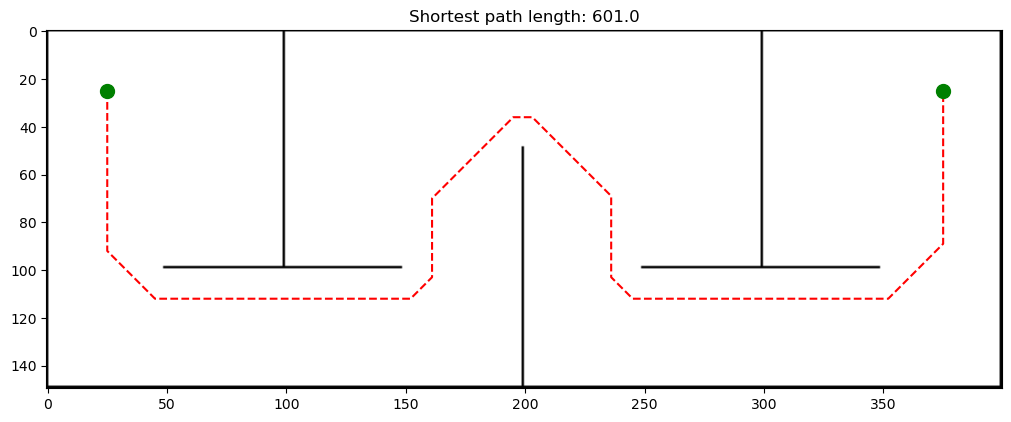

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,10), layout='constrained')
ax.imshow(map, cmap='gray_r')
ax.set_title('Shortest path length: %.1f' %length)
ax.plot(path[:,1], path[:,0], '--r', zorder=1)
ax.scatter(start[1], start[0], s=10**2, color='green', zorder=2)
ax.scatter(end[1], end[0], s=10**2, color='green', zorder=2)
plt.show()

# Safest path using voronoi diagrams

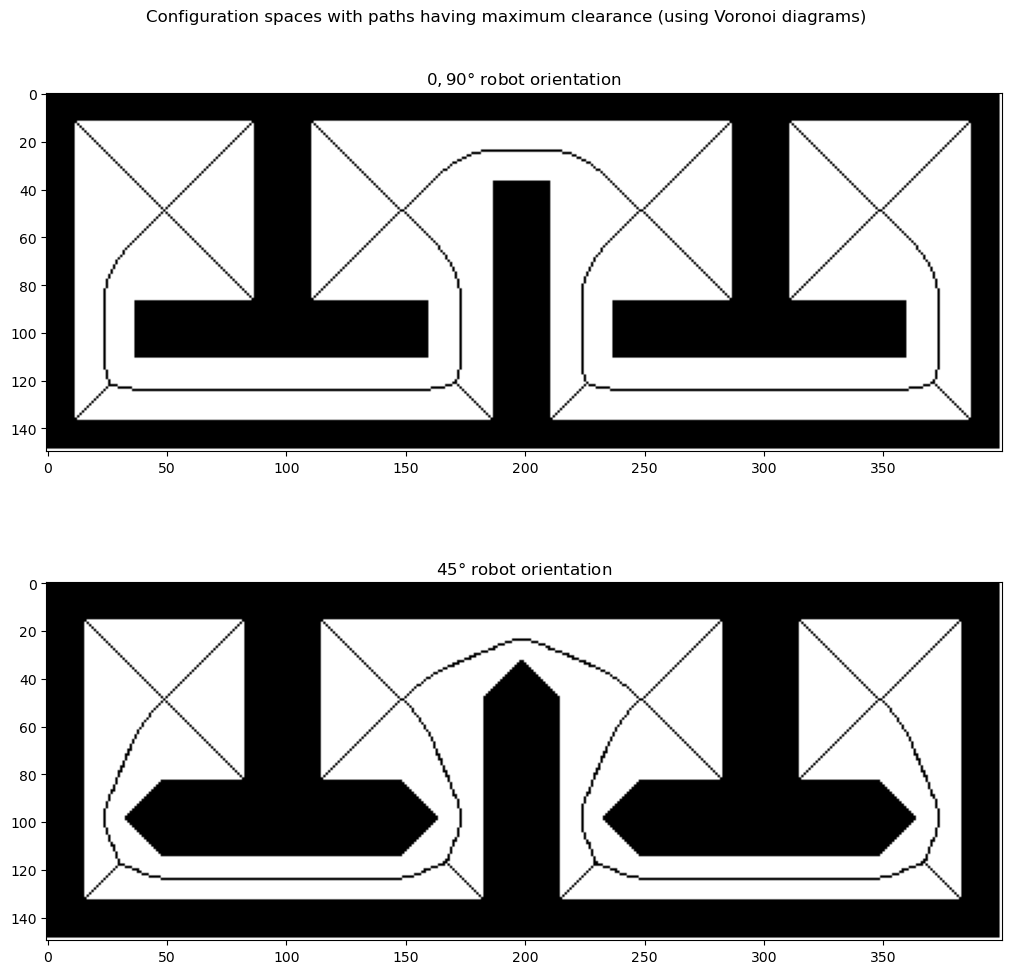

In [9]:
points0 = np.argwhere(config0==1)
points45 = np.argwhere(config45==1)
vor0 = Voronoi(points0)
vor45 = Voronoi(points45)

new_config0 = np.ones_like(config0)
new_config0[vor0.vertices[:,0].astype(int), vor0.vertices[:,1].astype(int)] = 0
new_config45 = np.ones_like(config45)
new_config45[vor45.vertices[:,0].astype(int), vor45.vertices[:,1].astype(int)] = 0


fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10,10), layout='constrained')
fig.suptitle('Configuration spaces with paths having maximum clearance (using Voronoi diagrams)')
ax0.imshow(new_config0, cmap='gray')
ax0.set_title('$0,90 \degree$ robot orientation')
ax1.imshow(new_config45, cmap='gray')
ax1.set_title('$45 \degree$ robot orientation')
plt.show()

new_config0[config0==1] = 1
new_config45[config45==1] = 1
new_config = np.logical_and(new_config0, new_config45)

These regions are the voronoi regions, and the edges are equidistant from the neighbouring obstacles with maximum clearance. Thus path planning along the edges would give us the safest path. However, since we have 2 voronoi diagrams for 2 robot orientations, we need to consider a union and path plan accordingly by considering both C-spaces.

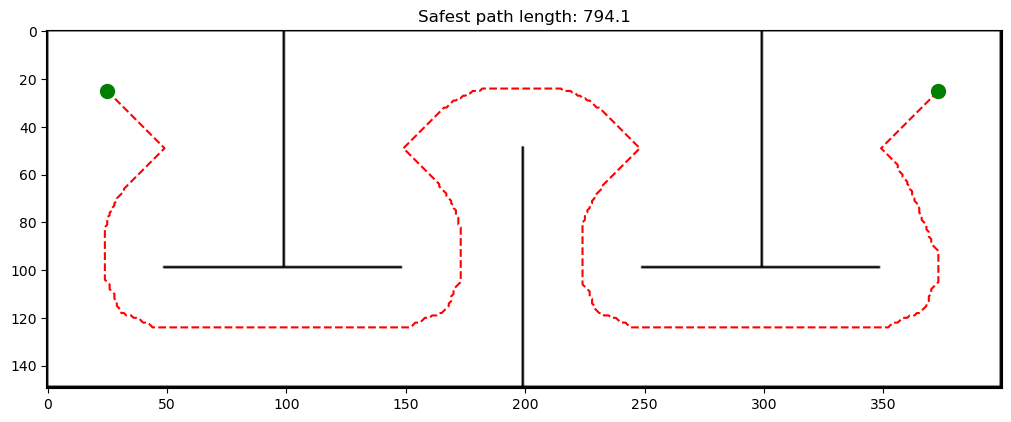

In [10]:
G = nx.Graph()
# Add nodes to the graph
for i in range(H):
    for j in range(W):
        for theta in thetas:

            if (evenMultiple(theta) and new_config[i,j] ==0) or \
                (oddMultiple(theta) and new_config[i,j] ==0):        # Use new_config0 when even multiple of 45, else config45
                G.add_node((i,j,theta))


for node in list(G.nodes):
    # Add edges for translation
    i,j,t = node
    di, dj = delta[t]
    G.add_edge(node, (i+di, j+dj, t))

    # Add edges for rotation
    if t == 0:
        G.add_edge(node, (i, j, 315))          
        G.add_edge(node, (i, j, 45))     
    elif t == 315:                              
        G.add_edge(node, (i, j, 0))            
        G.add_edge(node, (i, j, 270))        
    else:
        G.add_edge(node, (i, j, t + 45))
        G.add_edge(node, (i, j, t - 45))


# Invert x-y into i-j before running algorithm
start, end = (25,25,0), (25,373,0)
length, path = nx.bidirectional_dijkstra(G, start, end, weight = lambda u, v, d: np.sqrt((u[0]-v[0])**2 + (u[1]-v[1])**2))
path = np.array(path)

fig, ax = plt.subplots(1,1,figsize=(10,10), layout='constrained')
ax.imshow(map, cmap='gray_r')
ax.set_title('Safest path length: %.1f' %length)
ax.plot(path[:,1], path[:,0], '--r', zorder=1)
ax.scatter(start[1], start[0], s=10**2, color='green', zorder=2)
ax.scatter(end[1], end[0], s=10**2, color='green', zorder=2)
plt.show()

# Probabilistic Roadmaps (PRM)

To check for collisions b/w two nodes, we have used the $\texttt{bresenham}$ implementation, which returns the integer indices of the line b/w two points.

## Compute PRM path

### Define helper functions

In [11]:
def nodeDist(node1, node2):
    """
    Return distance between two nodes for sorting.
    """
    return np.sqrt((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)

def kNearest(cur_node, nodes, k):
    """
    Return list of k nearest nodes from a given node.
    """
    
    if len(nodes) == 1:     # Single element array at the beginning of RRT
        return nodes[0]
    elif k == 1:            # If only nearesk element is required and not list
        return sorted(nodes, key=lambda x: nodeDist(x, cur_node))[1]
    else:
        return sorted(nodes, key=lambda x: nodeDist(x, cur_node))[1:k+1]

def isCollisionFree(node1, node2):
    """
    Return whether a line connecting two nodes is collision free.
    """
    i1,j1,t1 = node1
    i2,j2,t2 = node2
    line = list(bresenham(i1, j1, i2, j2))
    
    if i1>=H or i1<0 or i2>=H or i2<0 or j1>=W or j1<0 or j2>=W or j2<0:
        return False        # Out of bounds condition
    
    for point in line:
        i,j = point
        if CSpace(0)[i,j] == 1 or CSpace(45)[i,j] == 1: 
            return False
    
    return True

### Create all possible nodes list to sample from

In [12]:
k = 25
nodes_all = []
start, end = (25,25,0), (25,373,0)

# Create a list of all nodes in graph
for i in range(H):
    for j in range(W):
        for theta in thetas:
                if CSpace(theta)[i,j]==0:        # Use new_config0 when even multiple of 45, else config45
                    nodes_all.append((i,j,theta))

### Plot PRM for different $N_\text{samples}$

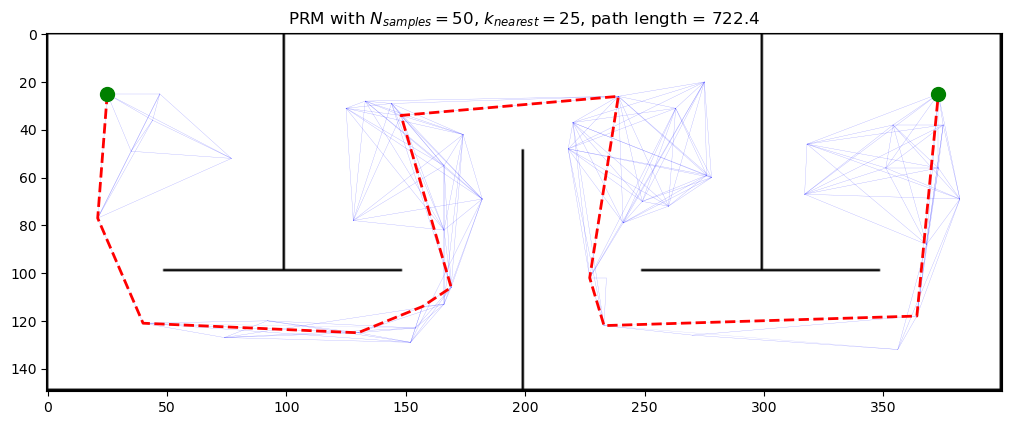

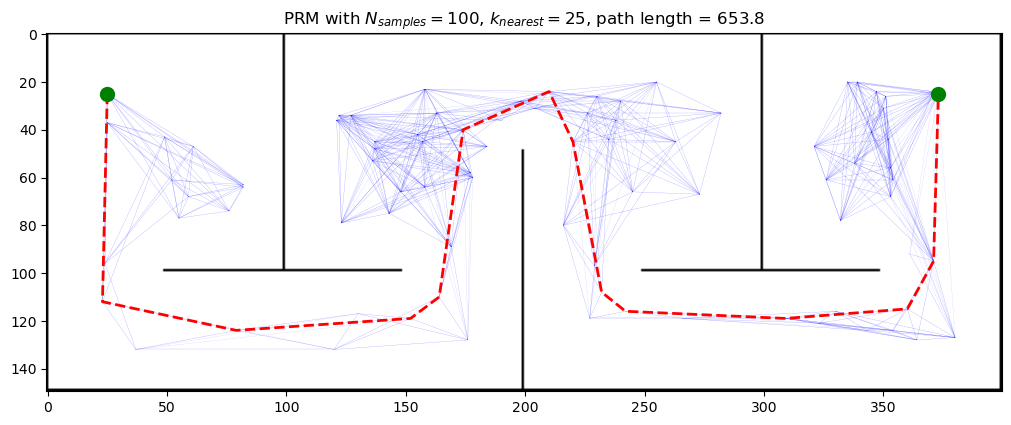

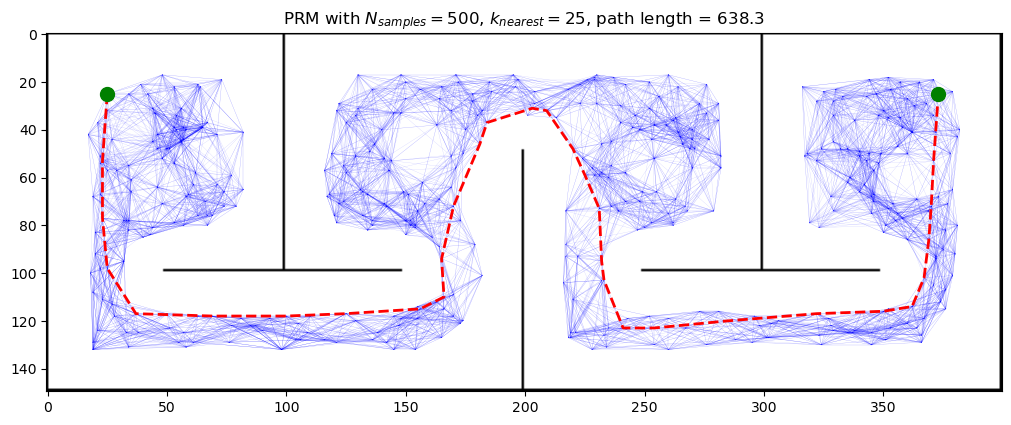

In [13]:
for n_samples in [50, 100, 500]:

    G = nx.Graph()

    # Add n_samples nodes to the graph randomly + start + end = n_samples+2 nodes
    G.add_node(start)
    G.add_node(end)
    for i in np.random.randint(len(nodes_all), size=n_samples):
        G.add_node(nodes_all[i])

    edges = []
    for node in list(G.nodes):

        i,j,t = node
        k_nearest_nodes = kNearest(node, list(G.nodes), k)

        for nearest_node in k_nearest_nodes:
            if isCollisionFree(node, nearest_node):
                G.add_edge(node, nearest_node)
                edges.append([node[0], node[1], nearest_node[0], nearest_node[1]])

    length, path = nx.bidirectional_dijkstra(G, start, end, weight = lambda u, v, d: np.sqrt((u[0]-v[0])**2 + (u[1]-v[1])**2))
    path = np.array(path)

    fig, ax = plt.subplots(1,1,figsize=(10,5), layout='constrained')
    ax.set_title('PRM with $N_{samples} = %d$, $k_{nearest} = %d$, path length = %.1f' %(n_samples, k, length))
    ax.imshow(map, cmap='gray_r', zorder=1)

    edges = np.array(edges)
    for i in range(edges.shape[0]):
        ax.plot([edges[i,1], edges[i,3]], [edges[i,0], edges[i,2]], linewidth=0.2, color='blue', alpha=0.2, zorder=2)

    # ax.scatter(np.array(G.nodes)[:,1], np.array(G.nodes)[:,0], s=1, color='black', zorder=3)
    ax.plot(path[:,1], path[:,0], '--r', linewidth=2,zorder=4)
    ax.scatter(start[1], start[0], s=10**2, color='green', zorder=5)
    ax.scatter(end[1], end[0], s=10**2, color='green', zorder=5)
    plt.show()

<center>

| $N_\text{samples}$ (with $k=25$)      | Path length (Euclidean units)	|
|---------------------	                |:-----------------------------:|
| 50            	                    |   722   	                    |
| 100            	                    |   654   	                    |
| 500            	                    |   638   	                    |

</center>

We see that with increasing number of samples, the path length tends to decrease. This is because a more dense graph is generated, and the planner can plan through finer edges/turns when needed.

We interestingly observe that with 50 samples, our algorithm **sometimes failed** to compute a valid path, since the nodes were

- either very far away, so that even $k=25$ nearest neighbours do not suffice
- not enough nodes were present to span the whole map such that edges are collision free.

For $N_\text{samples} \geq 100$, we do not face this problem as the sampled points usually span the entire graph such that collision free paths are available.

## Effect of k (no. of nearest neighbours for creating edges)

We want to observe the effect of *k* which is the no. of nearest nodes to connect the edges from another node. We sample a constant set of nodes ($N_\text{samples}=1000$), and then observe the effect of varying *k*.

### Create all possible nodes list to sample from

In [17]:
G_nodes = nx.Graph()
n_samples = 1000
nodes_all = []
start, end = (25,25,0), (25,373,0)
# Create a list of all nodes in graph
for i in range(H):
    for j in range(W):
        for theta in thetas:
                if CSpace(theta)[i,j]==0:        # Use new_config0 when even multiple of 45, else config45
                    nodes_all.append((i,j,theta))

# Add n_samples nodes to the graph randomly + start + end = 52 nodes
G_nodes.add_node(start)
G_nodes.add_node(end)
for i in np.random.randint(len(nodes_all), size=n_samples):
    G_nodes.add_node(nodes_all[i])

### Plot PRM for different $k$

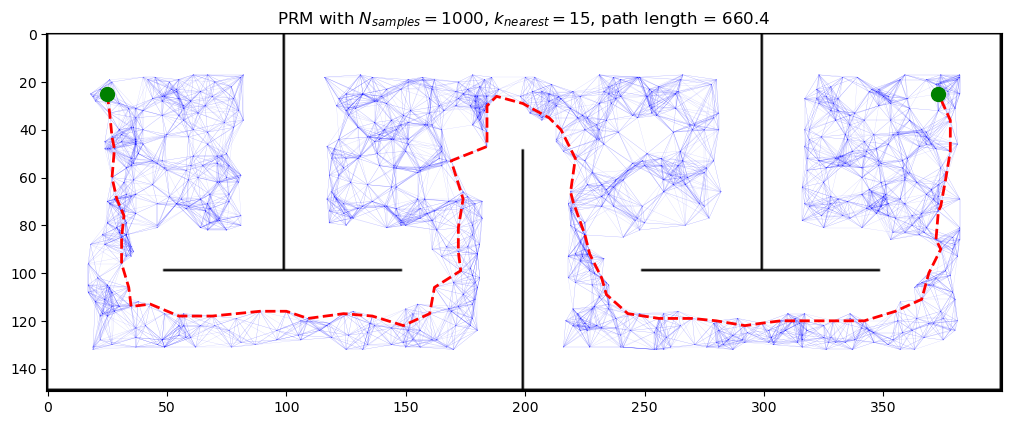

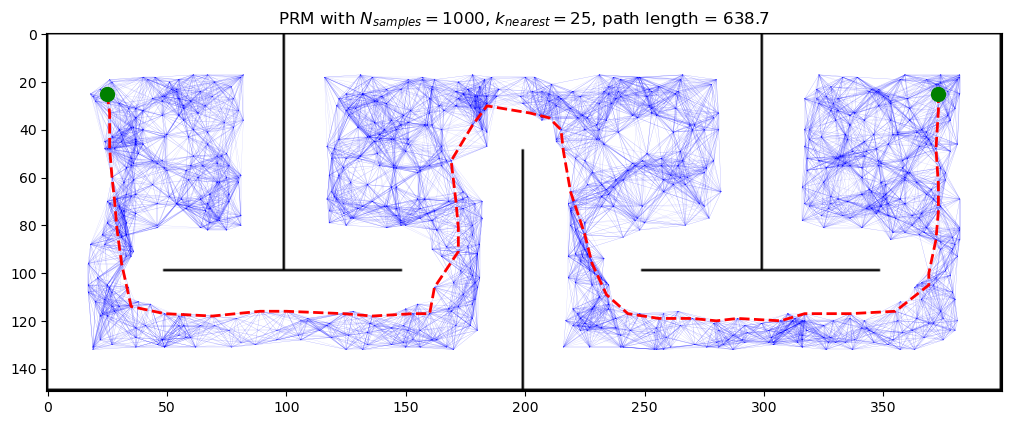

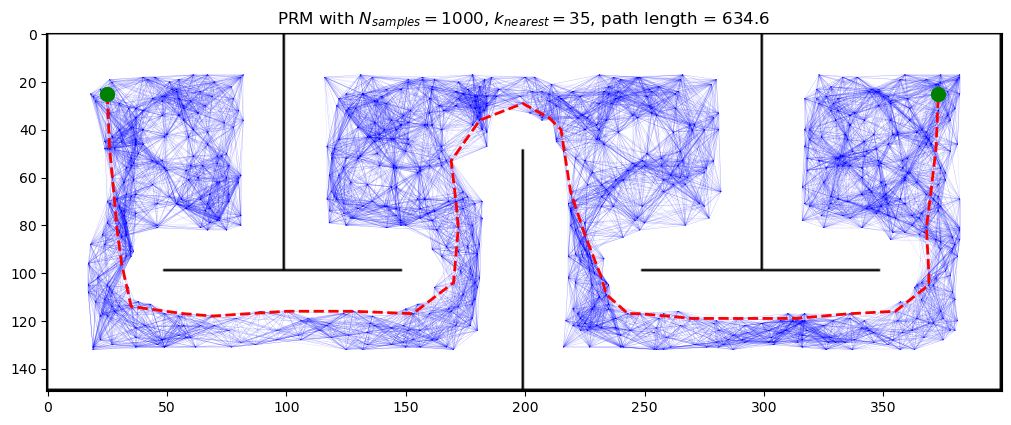

In [36]:
for k in [15, 25, 35]:
    edges=[]
    G = nx.Graph()
    G.add_nodes_from(G_nodes)

    for node in list(G.nodes):

        i,j,t = node
        k_nearest_nodes = kNearest(node, list(G.nodes), k)

        for nearest_node in k_nearest_nodes:
            if isCollisionFree(node, nearest_node):
                G.add_edge(node, nearest_node)
                edges.append([node[0], node[1], nearest_node[0], nearest_node[1]])

    length, path = nx.bidirectional_dijkstra(G, start, end, weight = lambda u, v, d: np.sqrt((u[0]-v[0])**2 + (u[1]-v[1])**2))
    path = np.array(path)

    fig, ax = plt.subplots(1,1,figsize=(10,5), layout='constrained')
    ax.set_title('PRM with $N_{samples} = %d$, $k_{nearest} = %d$, path length = %.1f' %(n_samples, k, length))
    ax.imshow(map, cmap='gray_r', zorder=1)

    edges = np.array(edges)
    for i in range(edges.shape[0]):
        ax.plot([edges[i,1], edges[i,3]], [edges[i,0], edges[i,2]], linewidth=0.2, color='blue', alpha=0.2, zorder=2)

    # ax.scatter(np.array(G.nodes)[:,1], np.array(G.nodes)[:,0], s=1, color='black', zorder=3)
    ax.plot(path[:,1], path[:,0], '--r', linewidth=2,zorder=4)
    ax.scatter(start[1], start[0], s=10**2, color='green', zorder=5)
    ax.scatter(end[1], end[0], s=10**2, color='green', zorder=5)
    plt.show()

<center>

| $k$ (with $N_\text{samples}=1000$)    | Path length (Euclidean units)	|
|---------------------	                |:-----------------------------:|
| 15               	                    |   660   	                    |
| 25            	                    |   639   	                    |
| 35            	                    |   635   	                    |

</center>

We see that with increasing $k$, our path length decreases. This is because at every node, we can now compute the shortest distance amongst a larger radius, and thus proceed towards a more optimal solution. A small $k$ only connects the edges in a smaller region, thus forgoing any potential better solution which passes through a distant node. This behaviour is similar to falling into a local minima (or taking the locally optimal solution instead of a global one).

Also, for lower $k=15$, the path has sharp turns, compared to ones with $k=25,35$. This is also due to the same reason; a small $k$ only looks at close neighbours, and thus has to make sudden turns. A larker $k$ allows for a more *global* lookout, and thus a more consistent path.

# RRT

### Helper functions

In [75]:
def steerNode(n1, n2, epsilon):
    """
    Returns new node end point after steering towards the random sample.
    """
    
    d = nodeDist(n1, n2)
    di, dj = int((epsilon / d) * (n2[0] - n1[0])), int((epsilon / d) * (n2[1] - n1[1]))
    return (n1[0] + di, n1[1] + dj, n1[2])

def isNewNode(n, G):
    """
    Return if the given node (for all thetas) is new or already added to the tree.
    """

    for t in thetas:
        if (n[0], n[1], t) in G:
            return False
    
    return True


### Define run parameters

In [140]:
nodes_all = []
start, end = (25,25,0), (25,375,0)

# Create a list of all nodes in graph
for i in range(H):
    for j in range(W):
        for theta in thetas:
                if CSpace(theta)[i,j]==0:        # Use new_config0 when even multiple of 45, else config45
                    nodes_all.append((i,j,theta))

### Run RRT for $N_{samples}$

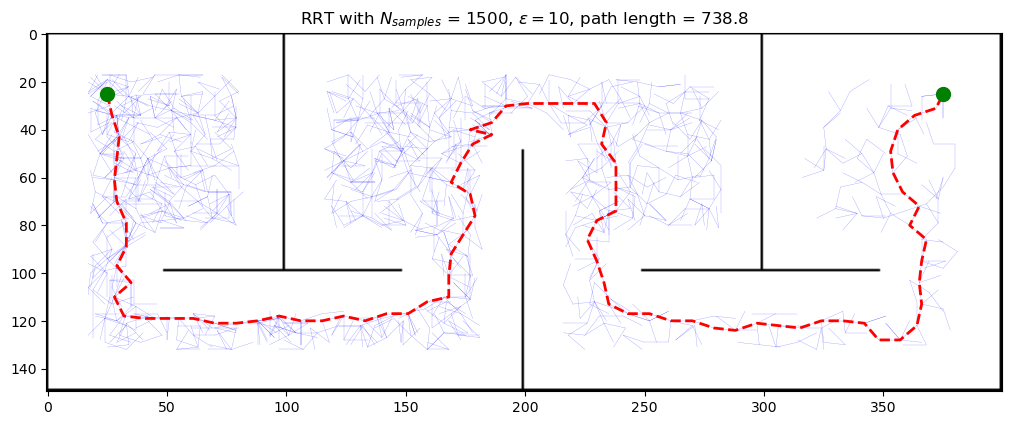

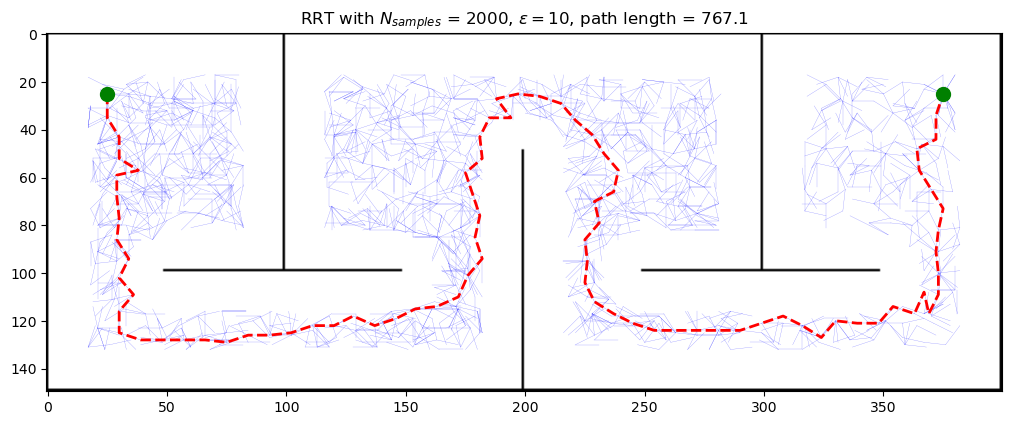

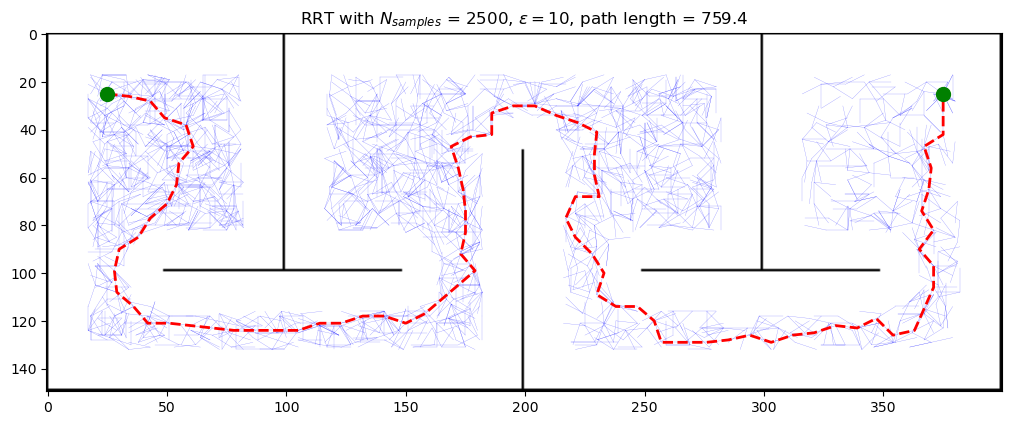

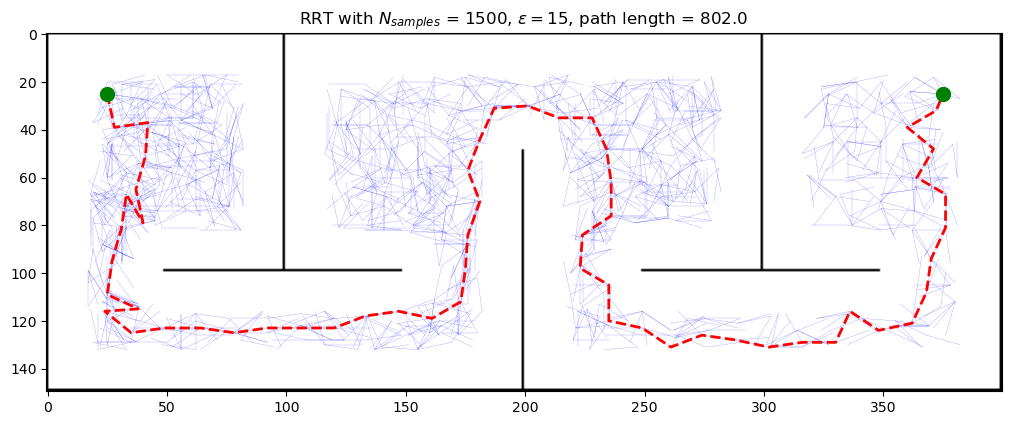

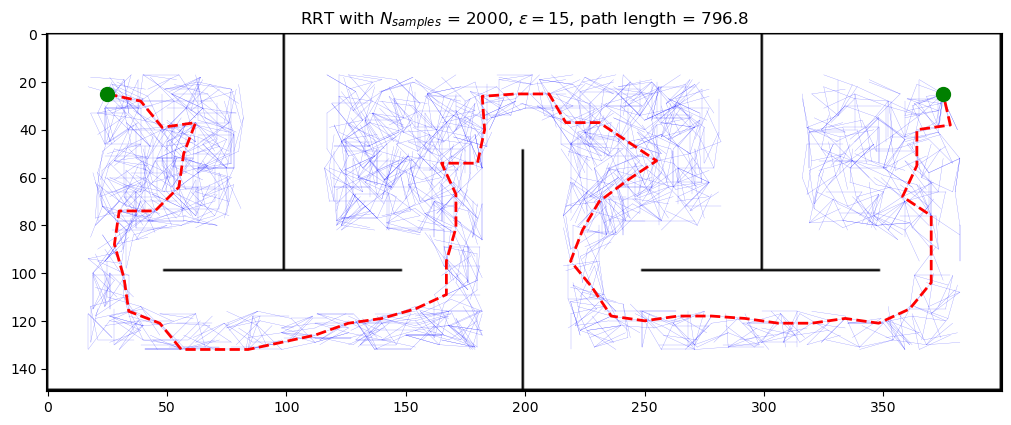

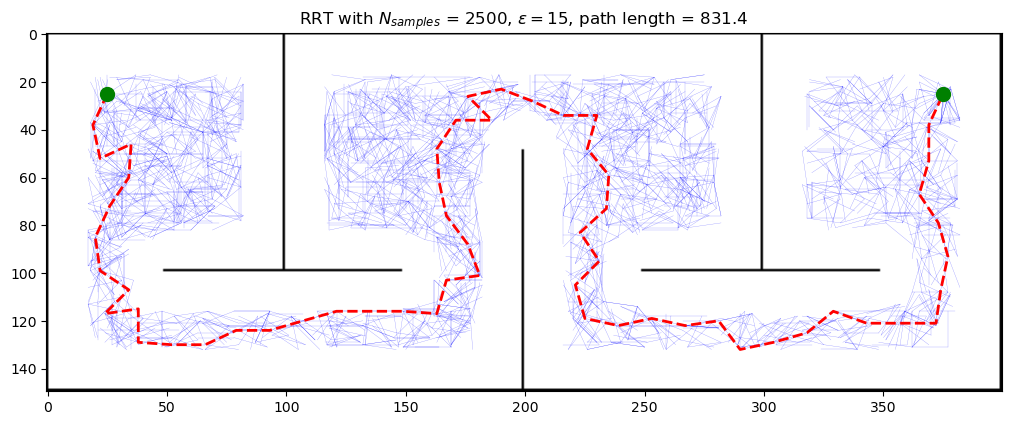

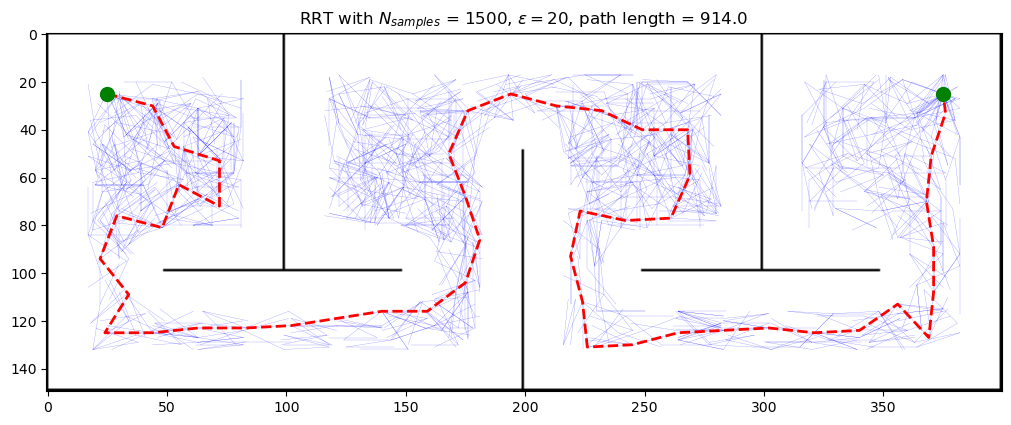

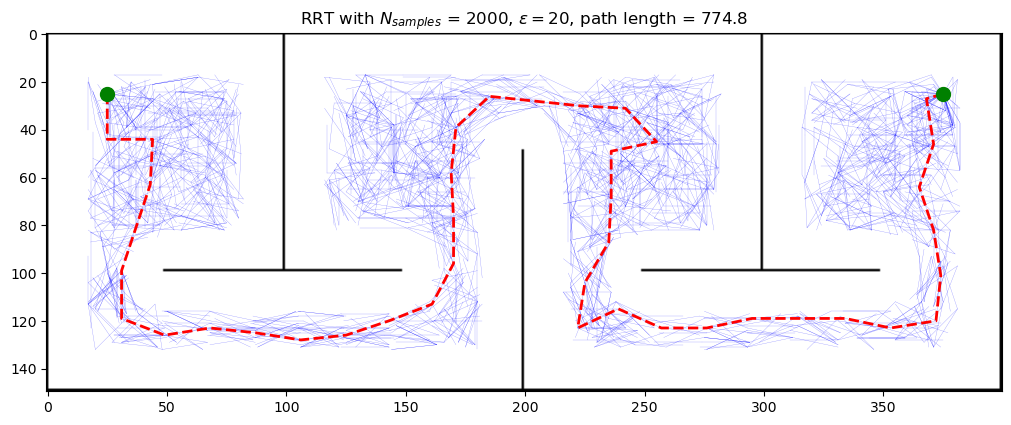

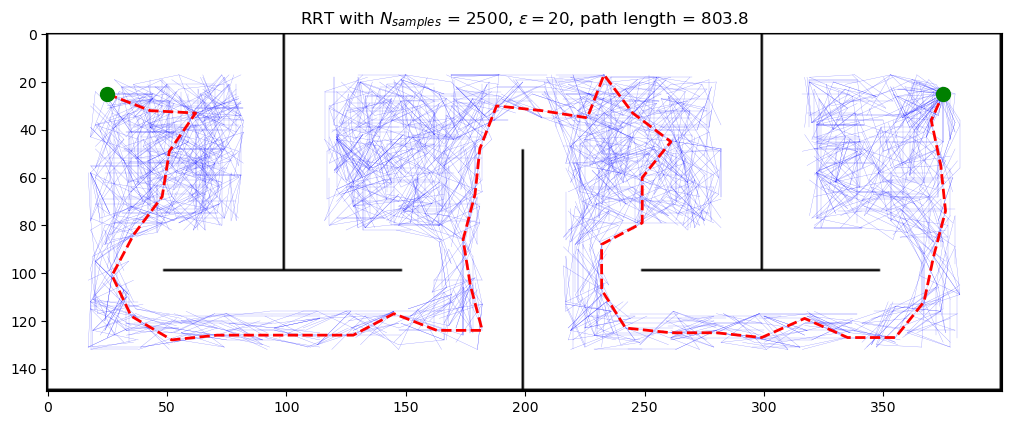

In [147]:
for epsilon in [10,15, 20]:             # length of path to be added to the tree in the direction of new sample
    for MAX_POINTS in [1500, 2000, 2500]:
        G = nx.Graph()
        G.add_node(start)
        n_points=0
        edges=[]
        
        while (n_points < MAX_POINTS):
            node = nodes_all[np.random.randint(len(nodes_all))]     # Pick a node randomly
            
            if isNewNode(node,G):
                nearest_node = kNearest(node, list(G.nodes), 1)
                new_node = steerNode(nearest_node, node, epsilon)

                # if nodeDist(nearest_node, new_node)>50 and isCollisionFree(nearest_node, new_node):
                if isCollisionFree(nearest_node, new_node):
                    G.add_node(new_node)
                    n_points+=1
                    G.add_edge(nearest_node, new_node)
                    edges.append([nearest_node[0], nearest_node[1], new_node[0], new_node[1], node[0], node[1]])
                
                    if isCollisionFree(new_node, end) and nodeDist(new_node, end) <= epsilon:
                        G.add_node(end)
                        n_points+=1
                        G.add_edge(new_node, end)
                        edges.append([new_node[0], new_node[1], end[0], end[1], node[0], node[1]])


        length, path = nx.bidirectional_dijkstra(G, start, end, weight = lambda u, v, d: np.sqrt((u[0]-v[0])**2 + (u[1]-v[1])**2))
        path = np.array(path)

        fig, ax = plt.subplots(1,1,figsize=(10,5), layout='constrained')
        ax.set_title('RRT with $N_{samples}$ = %d, $\epsilon = %d$, path length = %.1f' %(MAX_POINTS, epsilon, length))
        ax.imshow(map, cmap='gray_r', zorder=1)

        edges = np.array(edges)
        for i in range(edges.shape[0]):
            ax.plot([edges[i,1], edges[i,3]], [edges[i,0], edges[i,2]], linewidth=0.2, color='blue', alpha=0.5, zorder=2)

        # ax.scatter(np.array(G.nodes)[:,1], np.array(G.nodes)[:,0], s=1, color='black', zorder=3)
        ax.plot(path[:,1], path[:,0], '--r', linewidth=2,zorder=4)
        ax.scatter(start[1], start[0], s=10**2, color='green', zorder=5)
        ax.scatter(end[1], end[0], s=10**2, color='green', zorder=5)
        plt.show()

<center>
<b>Path length</b>

| $N_\text{samples}$ 	| $\epsilon = 10$ 	| $\epsilon = 15$ 	| $\epsilon = 20$ 	|
|:------------------:	|:---------------:	|:---------------:	|:---------------:	|
|        1500        	|       739       	|       802       	|       914       	|
|        2000        	|       767       	|       797       	|       775       	|
|        2500        	|       759       	|       831       	|       804       	|

</center>

We observe that RRT works well enough for low $\epsilon$ and high $N_\text{samples}$. A low $\epsilon$ means that the tree is expanded slowly, and thus requires a lot more samples to be drawn. However, that means that deviation from a potentially suboptimal path is low, and the algorithm has ample opportunities to get on a closer-to-optimal path. With high $\epsilon$, a suboptimal node can be added to the tree, and can cause the path length to be larger if that is the only feasible node in that particular map region. Thus cost of deviations is high in case of high $\epsilon$.

Thus a balance between $N_\text{samples}$ and $\epsilon$ is very important. In some cases, increasing $N_\text{samples}$ is detrimental to the algorithm, since the node selection is random. 

In PRM, we do not use an $\epsilon$ parameter, rather we use $k$ nearest neighbours. Thus nodes far away can also be connected to the graph.